In [15]:
module ResetMclWorld

using Plots
using Distributions
using StatsBase
using LinearAlgebra
using Printf
using Logging
Logging.disable_logging(Logging.Info)

include("../scripts/mcl.jl")
import .MclWorld: RealRobot, RealCamera
import .MclWorld: IdealAgent, Agent, EstimationAgent, Landmark, Map, Camera, Robot, World
import .MclWorld: data, decision, state_transition, circle_shape, draw, append
import .MclWorld: Estimator, Particle, set_ml, motion_update, observation_update, resampling_system

mutable struct ResetMcl <: Estimator
    init_pose::Array{Float64}
    num::Int64
    map::Map
    particles::Array{Particle}
    distance_dev_rate::Float64
    direction_dev::Float64
    motion_noise_rate_pdf::MvNormal
    ml::Particle
    pose::Array{Float64}
    amcl_params::Dict
    slow_term_alpha::Float64
    fast_term_alpha::Float64

    function ResetMcl(
        init_pose,
        num;
        map=Map(),
        particles=[Particle(init_pose, 1.0/num) for i in 1:num],
        distance_dev_rate=0.14,
        direction_dev=0.05,
        motion_noise_stds=Dict([("nn", 0.19), ("no", 0.001), ("on", 0.13), ("oo", 0.2)]),
        ml = particles[1],
        pose = ml.pose,
        amcl_params=Dict([("slow", 0.001), ("fast", 0.1), ("nu", 3.0)]),
        slow_term_alpha=1.0,
        fast_term_alpha=1.0
        )
    
        c = diagm([motion_noise_stds["nn"]^2, motion_noise_stds["no"]^2, motion_noise_stds["on"]^2, motion_noise_stds["oo"]^2])
        motion_noise_rate_pdf = MvNormal([0, 0, 0, 0], c)
    
        new(
            init_pose,
            num,
            map,
            particles,
            distance_dev_rate,
            direction_dev,
            motion_noise_rate_pdf,
            ml,
            pose,
            amcl_params,
            slow_term_alpha,
            fast_term_alpha
        )
    end

end

function sensor_resetting_draw(self::Estimator, particle, landmark_pos, ell_obs, phi_obs)
    ## パーティクルの位置を決める
    psi = rand(Uniform(-pi, pi))
    ell = rand(Normal(ell_obs, (ell_obs*self.distance_dev_rate)^2))
    particle.pose[1] = landmark_pos[1] + ell*cos(psi)
    particle.pose[2] = landmark_pos[2] + ell*sin(psi)
    
    ## パーティクルの向きを決める
    phi = rand(Normal(phi_obs, (self.direction_dev)^2))
    particle.pose[3] = atan(landmark_pos[2] - particle.pose[2], landmark_pos[1]-particle.pose[1]) - phi
    
    particle.weight = 1.0 / length(self.particles) #重みを1/Nに    
end

function adaptive_resetting(self::Estimator, observation)    

    if length(observation) == 0
        return
    end
    
    #センサリセットするパーティクルの数を決める
    alpha = sum([p.weight for p in self.particles])
    self.slow_term_alpha = self.slow_term_alpha + self.amcl_params["slow"]*(alpha-self.slow_term_alpha)
    self.fast_term_alpha = self.fast_term_alpha + self.amcl_params["fast"]*(alpha-self.fast_term_alpha)
    sl_num = length(self.particles)*maximum([0.0, 1.0-self.amcl_params["nu"]*self.fast_term_alpha/self.slow_term_alpha])

    resampling_system(self) # とりあえず普通にサンプリング
    
    dist_obs = Dict((key, val[1]) for (key, val) in observation)
    nearest_obs_id = argmin(dist_obs)
    values = observation[nearest_obs_id]

    for n in 1:floor(sl_num) # n個パーティクルを選んで姿勢を変える（２回以上姿勢を変えられるパーティクルがあるけどとりあえず気にしない）            
        p = sample(self.particles, 1)
        sensor_resetting_draw(self, p, self.map.landmarks[nearest_obs_id].pos, values[1], values[2])
    end
end

function observation_update(self::Estimator, observation)
    for p in self.particles
        observation_update(p, observation, self.map, self.distance_dev_rate, self.direction_dev)
    end
        
    set_ml(self)
    adaptive_resetting(self, observation)
end

end

Main.ResetMclWorld

Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_advanced_localization/tmp.gif")
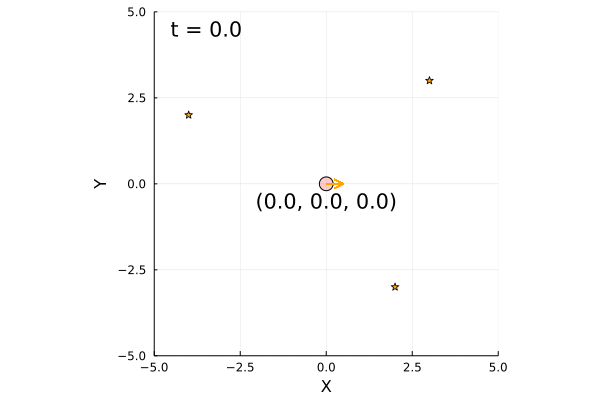

In [17]:
using .ResetMclWorld
using Distributions

function trial(animation=true)

    time_interval = 0.1    
    world = ResetMclWorld.World(30, 0.1)

    ### 地図を生成して2つランドマークを追加 ###
    m = ResetMclWorld.Map()
    ResetMclWorld.append(m, ResetMclWorld.Landmark([-4, 2]))
    ResetMclWorld.append(m, ResetMclWorld.Landmark([2, -3]))
    ResetMclWorld.append(m, ResetMclWorld.Landmark([3, 3]))
    ResetMclWorld.append(world, m)

    initial_pose = [0.0, 0.0, 0.0]
    pf = ResetMclWorld.ResetMcl(initial_pose, 100, map=m)
    a = ResetMclWorld.EstimationAgent(time_interval, 0.2, 10.0/180.0*pi, pf)
    r = ResetMclWorld.RealRobot(initial_pose, :red, 0.2, a, sensor=ResetMclWorld.RealCamera(m), expected_kidnap_time=100.0)
    ResetMclWorld.append(world, r)

    if animation
        ResetMclWorld.draw(world)
    else
        ResetMclWorld.draw(world)
        return r.pose, pf.ml.pose
    end
end

trial()